# **Task 2 (75 points):**
In this task, you will pick a dataset (time-series or any other form of
sequential data) and an associated problem that can be solved via sequence models. You must
describe why you need sequence models to solve this problem. Include a link to the dataset
source. Next, you should pick an RNN framework that you would use to solve this problem (This
framework can be in TensorFlow, PyTorch or any other Python Package).

In [1]:
# prompt: connect google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
ls drive/MyDrive/RPI/Spr2025/ProjAiMl/homework4/

homework4  YoutubeCommentsDataSet.csv


https://www.kaggle.com/datasets/atifaliak/youtube-comments-dataset

In [3]:
# Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

df = pd.read_csv("drive/MyDrive/RPI/Spr2025/ProjAiMl/homework4/YoutubeCommentsDataSet.csv")
SEED = 5555

In [4]:
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


The checking of null values in the dataset ensures data integrity and reduces the need for data preprocessing steps. This can potentially improve the training efficiency and effectiveness of the model.

In [5]:
df.isnull().sum()

,0
Comment,44
Sentiment,0


In [6]:
# Remove rows with NaNs in the 'Comment' column
df = df.dropna(subset=['Comment'])

The first column labeled Comment was cleaned up removing null values from the dataset. Removing NaNs helps improve the clarity and efficiency of subsequent data processing and model training.

In [7]:
len(df[df["Sentiment"]== "negative"]) # negative

2337

In [8]:
len(df[df["Sentiment"]== "neutral"]) # neutral

4625

In [9]:
len(df[df["Sentiment"]== "positive"]) # positive

11402

Analysis of the data revealed a class imbalance, with significantly more positive comments (11432) than negative comments (2338). To address this and ensure a more balanced representation during model training, a downsampling technique was used. This involved randomly removing a specific number of observations from the majority class (positive comments) to match the size of the middle class (neutral comments).

In [10]:
from sklearn.utils import resample

# Load the dataset (assuming you have it in a DataFrame called 'df')

# Identify indices of negative comments
positive_indices = df[df['Sentiment'] == 'positive'].index
neutral_indices = len(df[df['Sentiment'] == 'neutral'])

# Calculate the number of negative comments to remove based on desired ratio or fixed number
num_positive_to_remove = len(positive_indices) - neutral_indices  # For 1:1 ratio

# Create a DataFrame of just those indices
positives_to_remove = positive_indices.to_frame(name='index')

# Undersample the positives to remove (if any)
if num_positive_to_remove > 0:
    df_downsampled = resample(positives_to_remove,
                              replace=False,  # Don't sample with replacement
                              n_samples=num_positive_to_remove,
                              random_state=42)  # For reproducibility

    # Drop those indices from the original DataFrame
    df = df.drop(df_downsampled['index'])

# Check the new distribution
print("Sentiment distribution after undersampling:")
print(df['Sentiment'].value_counts())

Sentiment distribution after undersampling:
Sentiment
neutral     4625
positive    4625
negative    2337
Name: count, dtype: int64


In [11]:
df = df[df["Sentiment"] != "neutral"]# remove neutral
len(df)

6962

In [12]:
df["Sentiment"] = df["Sentiment"].replace("negative", 0)
df["Sentiment"] = df["Sentiment"].replace("positive", 1)

<ipython-input-12-4c97a0082053>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Sentiment"] = df["Sentiment"].replace("positive", 1)


This dataset includes YouTube comments categorized under the sentiments: bad, neutral, and good. To focus on identifying distinctly negative or positive sentiments, neutral observations were removed. This decision was made because neutral comments might not contribute strongly to model training when the goal is to distinguish between clear emotional states. Despite this filtering, we retain a substantial dataset that provides ample data for robust model training.

**Part 1 (10 points):** Implement your RNN either using an existing framework OR you can
implement your own RNN cell structure. In either case, describe the structure of your
RNN and the activation functions you are using for each time step and in the output
layer. Define a metric you will use to measure the performance of your model (NOTE:
Performance should be measured both for the validation set and the test set).

In [13]:
df

,Comment,Sentiment
1,here in nz 50 of retailers don’t even have con...,0
3,whenever i go to a place that doesn’t take app...,0
4,apple pay is so convenient secure and easy to ...,1
6,we only got apple pay in south africa in 20202...,1
10,wow you really went to town on the psu test ra...,1
...,...,...
18391,i love the way you explained plus the diversity,1
18394,awesome succinct very effective for a newbie t...,1
18397,thanks for sharing what is machine learning us...,1
18400,ive worked for about 2 years with mlcomputer v...,1


In [14]:
import re

def clean_comment(comment: str) -> str:
    """
    Cleans text, removing special characters, hashtags, and mentions while
    preserving spaces and essential punctuation.

    Args:
        comment: The text to be cleaned.

    Returns:
        The cleaned text.
    """

    # Regular expression to match and remove special characters
    pattern = r"[^a-zA-Z0-9\s\.!?,\(\)]+"

    # Clean the text using regular expressions
    cleaned_text = re.sub(pattern, "", comment)

    # Remove leading and trailing whitespace
    cleaned_text = cleaned_text.strip()

    return cleaned_text

# Apply the cleaning function to the "Comment" column
df["Comment"] = df["Comment"].apply(clean_comment)


In [15]:
df

,Comment,Sentiment
1,here in nz 50 of retailers dont even have cont...,0
3,whenever i go to a place that doesnt take appl...,0
4,apple pay is so convenient secure and easy to ...,1
6,we only got apple pay in south africa in 20202...,1
10,wow you really went to town on the psu test ra...,1
...,...,...
18391,i love the way you explained plus the diversity,1
18394,awesome succinct very effective for a newbie t...,1
18397,thanks for sharing what is machine learning us...,1
18400,ive worked for about 2 years with mlcomputer v...,1


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
def convert_to_tfds(dataframe):

  dataset = tf.data.Dataset.from_tensor_slices((dataframe['Comment'], dataframe['Sentiment']))
  dataset = dataset.shuffle(buffer_size=len(dataframe), seed=0)
  return dataset.batch(64).prefetch(tf.data.AUTOTUNE)

training_set = df.copy()

train, dev = train_test_split(training_set, test_size=0.1, random_state = 0)
train, test = train_test_split(train, test_size = 0.1, random_state = 0)

train_ds = convert_to_tfds(train)
valid_ds = convert_to_tfds(dev)
test_ds = convert_to_tfds(test)

In [18]:
encoder = tf.keras.layers.TextVectorization()
encoder.adapt(train_ds.map(lambda text, label: text))

In [19]:
len(encoder.get_vocabulary())

16566

In [20]:
model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim = len(encoder.get_vocabulary()),
            output_dim = 64,
            mask_zero = True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64, activation='relu')),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
])

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [22]:
history = model.fit(train_ds, epochs=15,
                    validation_data=valid_ds,
                    validation_steps=30)

Epoch 1/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 311ms/step - accuracy: 0.3643 - loss: 0.6773 - val_accuracy: 0.6112 - val_loss: 0.6212
Epoch 2/15
 1/89 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.6562 - loss: 0.5960

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - accuracy: 0.6477 - loss: 0.6260 - val_accuracy: 0.6772 - val_loss: 0.5974
Epoch 3/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 22s 245ms/step - accuracy: 0.7148 - loss: 0.5870 - val_accuracy: 0.7217 - val_loss: 0.5533
Epoch 4/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step - accuracy: 0.8023 - loss: 0.5130 - val_accuracy: 0.7719 - val_loss: 0.4815
Epoch 5/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.8597 - loss: 0.4263 - val_accuracy: 0.7948 - val_loss: 0.4333
Epoch 6/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.9009 - loss: 0.3322 - val_accuracy: 0.7977 - val_loss: 0.6785
Epoch 7/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 215ms/step - accuracy: 0.9056 - loss: 0.2341 - val_accuracy: 0.8307 - val_loss: 0.3672
Epoch 8/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 22s 213ms/step - accuracy: 0.9520 - loss: 0.1396 - val_accuracy: 0.8321 - val_loss: 0.3737
Epoch 9/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 0.9704 - loss: 0.0872 - val_accuracy: 0.837

In [23]:
# Get Loss and Accuracy of test set
loss, accuracy = model.evaluate(test_ds)

print('Loss:', loss)
print('Accuracy:', accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8434 - loss: 0.5844
Loss: 0.657492995262146
Accuracy: 0.8341307640075684


This model utilizes a bidirectional recurrent neural network (BRNN) with an embedding layer for processing tokenized input data.

* **Rapid Initial Improvement:** The model exhibited rapid improvement in accuracy and loss reduction during the early epochs (1-5). Training accuracy climbed from 36.43% in Epoch 1 to 85.97% in Epoch 5, with a corresponding decrease in loss.
* **Overfitting:** After epoch 5, the model begins to overfit. The training accuracy continues to increase, reaching 99.63% by Epoch 15, while the validation accuracy plateaus and even declines in some epochs, indicating overfitting. The validation loss also increases after epoch 7.
* **Epoch 2 issue:** It is important to note the warning from epoch 2. "Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least steps_per_epoch * epochs batches. This issue should be investigated. Suggestion to use .repeat() or simplify model complexity so that you can ensure the dataset can provide enough batches for the training process.

**Part 2 (30 points):** Update your network from part 1 with first an LSTM and then a GRU
based cell structure (You can treat both as 2 separate implementations). Re-do the
training and performance evaluation. What are the major differences you notice? Why
do you think those differences exist between the 3 implementations (basic RNN, LSTM
and GRU)?

In [24]:
# LSTM Implementation

model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim = len(encoder.get_vocabulary()),
            output_dim = 64,
            mask_zero = True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu')),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
])

In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [26]:
history = model.fit(train_ds, epochs=15,
                    validation_data=valid_ds,
                    validation_steps=30)

Epoch 1/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 44s 422ms/step - accuracy: 0.3408 - loss: 0.6915 - val_accuracy: 0.3085 - val_loss: 0.6665
Epoch 2/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 43s 486ms/step - accuracy: 0.3648 - loss: 0.6596 - val_accuracy: 0.6356 - val_loss: 0.6101
Epoch 3/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 76s 420ms/step - accuracy: 0.6456 - loss: nan - val_accuracy: 0.3085 - val_loss: nan
Epoch 4/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 39s 446ms/step - accuracy: 0.3357 - loss: nan - val_accuracy: 0.3085 - val_loss: nan
Epoch 5/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - accuracy: 0.3313 - loss: nan - val_accuracy: 0.3085 - val_loss: nan
Epoch 6/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 36s 400ms/step - accuracy: 0.3522 - loss: nan - val_accuracy: 0.3085 - val_loss: nan
Epoch 7/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 39s 441ms/step - accuracy: 0.3360 - loss: nan - val_accuracy: 0.3085 - val_loss: nan
Epoch 8/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 39s 445ms/step - accuracy: 0.3421 - loss: nan - val_accuracy: 0.3085 - val_loss: nan
Epoc

In [27]:
# LSTM Implementation - Get Loss and Accuracy of test set
loss, accuracy = model.evaluate(test_ds)

print('Loss:', loss)
print('Accuracy:', accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.3237 - loss: nan
Loss: nan
Accuracy: 0.339712917804718


In [28]:
# GRU Implementation

model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim = len(encoder.get_vocabulary()),
            output_dim = 64,
            mask_zero = True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='relu')),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
])

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [30]:
history = model.fit(train_ds, epochs=15,
                    validation_data=valid_ds,
                    validation_steps=30)

Epoch 1/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 48s 479ms/step - accuracy: 0.3417 - loss: 0.6852 - val_accuracy: 0.3085 - val_loss: 0.6500
Epoch 2/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 81s 460ms/step - accuracy: 0.4043 - loss: 0.6467 - val_accuracy: 0.6801 - val_loss: 0.6074
Epoch 3/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - accuracy: 0.6635 - loss: 0.6128 - val_accuracy: 0.7030 - val_loss: 0.5760
Epoch 4/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - accuracy: 0.7315 - loss: nan - val_accuracy: 0.3085 - val_loss: nan
Epoch 5/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 42s 476ms/step - accuracy: 0.3378 - loss: nan - val_accuracy: 0.3085 - val_loss: nan
Epoch 6/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 465ms/step - accuracy: 0.3393 - loss: nan - val_accuracy: 0.3085 - val_loss: nan
Epoch 7/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 455ms/step - accuracy: 0.3397 - loss: nan - val_accuracy: 0.3085 - val_loss: nan
Epoch 8/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 463ms/step - accuracy: 0.3388 - loss: nan - val_accuracy: 0.3085 - val_loss: na

In [31]:
# GRU Implementation - Get Loss and Accuracy of test set
loss, accuracy = model.evaluate(test_ds)

print('Loss:', loss)
print('Accuracy:', accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.3220 - loss: nan
Loss: nan
Accuracy: 0.339712917804718


**Comparison of RNN Architectures:**

* **LSTM:**
  * The LSTM model's training process began with moderate accuracy and loss.
  * However, after the second epoch, the training resulted in "nan" loss and a consistent accuracy of around 33-35%.
  * The validation accuracy also remained consistently low at approximately 30%.
  * The test loss was nan, and the test accuracy was 33.97%.
  * These results strongly suggest that the LSTM model encountered significant numerical instability (likely due to vanishing or exploding gradients), preventing effective learning.
* **GRU:**
  * The GRU model showed some initial improvement, with accuracy increasing and loss decreasing in the first few epochs.
  * However, similar to the LSTM, the GRU model also encountered numerical instability, resulting in "nan" loss and a consistently low accuracy of around 33-35% after epoch 3.
  * The validation accuracy also remained consistently low at approximately 30%.
  * The test loss was nan, and the test accuracy was 33.97%.
  * This indicates that the GRU model also suffered from instability issues.

**Potential Contributing Factor:**

  * Numerical Instability: The "nan" loss values strongly suggest numerical instability, likely caused by vanishing or exploding gradients. This is a common problem with recurrent neural networks, especially LSTMs and GRUs, when dealing with long sequences or poorly scaled data.
  * Data Characteristics:
    * The significant variation in comment lengths (ranging from one word to lengthy comments) might have exacerbated the instability issues.
    * The complexity of the data itself could also be a contributing factor.

**Part 3 (10 points):** Can you use the traditional feed-forward network to solve the same
problem. Why or why not? (Hint: Can time series data be converted to usual features
that can be used as input to a feed-forward network?)

While you can technically convert time series data (like comment text) into features for a feed-forward network (e.g., using techniques like bag-of-words or TF-IDF), it would lose the crucial sequential information inherent in language. Feed-forward networks treat each word independently, failing to capture the context and order that are vital for accurate sentiment analysis. For example, "not good" and "good not" would be treated similarly.

To improve performance with RNNs, we would:

* Implement gradient clipping and normalization to stabilize training.
Thoroughly tune hyperparameters, especially for LSTMs and GRUs.
* Review and refine data preprocessing, focusing on consistent input scaling and handling length variations.
Try a simpler model.
* Investigate the dataset for possible errors.


These adjustments should help mitigate instability and improve sentiment analysis accuracy on the YouTube comments dataset.

# **Task 3 (50 points):**

**Part 1: Implementing Word Embeddings (10 points)**

* Use a pre-trained word embedding model (Word2Vec, GloVe, FastText, or BERT
embeddings).
* Provide a comparative discussion on why you chose this embedding over others.
* Load embeddings efficiently (either from pre-trained vectors or using an NLP library like
Gensim, SpaCy, or Hugging Face).
* Allow dynamic user input of two words and output their respective embeddings.
* Handle cases where a word is out of vocabulary (OOV) and suggest ways to approximate
its embedding.

In [34]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.0 MB/s eta 0:00:00


In [42]:
from sentence_transformers import SentenceTransformer
#  Load Embeddings from Hugging Face Hub
model = SentenceTransformer("cicero-ai/average_word_embeddings_glove.6B.300d-rust")


#  User Input and Embedding Output
def get_word_embedding(word, model):
    try:
        embedding = model.encode(word)
        return embedding
    except KeyError:
        return None

def handle_oov(word, model):
    print(f"Word '{word}' is out of vocabulary.")
    return np.zeros(model.get_sentence_embedding_dimension()) # Return a zero vector with the same dimensions as the embeddings

**Comparative Discussion:**
 Why GloVe (from Hugging Face)?
 - Using a Hugging Face model simplifies loading and access.
 - GloVe is efficient and captures semantic relationships.
 - This specific model provides 300-dimensional embeddings.
 - Hugging Face provides a central place to access models, and integrates well with other libraries.
 - Word2Vec, FastText, BERT: Same as before, but the loading method changes.

In [44]:
while True:
    word1 = input("Enter the first word (or 'exit'): ").lower()
    if word1 == 'exit':
        break
    word2 = input("Enter the second word (or 'exit'): ").lower()
    if word2 == 'exit':
        break

    embedding1 = get_word_embedding(word1, model)
    embedding2 = get_word_embedding(word2, model)

    if embedding1 is None:
        embedding1 = handle_oov(word1, model)

    if embedding2 is None:
        embedding2 = handle_oov(word2, model)

    print(f"Embedding for '{word1}': {embedding1}")
    print(f"Embedding for '{word2}': {embedding2}")

Enter the first word (or 'exit'): apple 
Enter the second word (or 'exit'): banana
Embedding for 'apple ': [-0.20842   -0.019668   0.063981  -0.71403   -0.21181   -0.59283
 -0.15316    0.044217   0.63289   -0.84821   -0.21129   -0.19763
  0.19029   -0.56226    0.27126    0.23782   -0.5189    -0.24518
  0.035243   0.096833   0.24898    0.71279    0.038279  -0.10514
 -0.4779    -0.39515   -0.27194   -0.44428    0.06113   -0.2318
 -0.35901   -0.18239    0.035507  -0.087719  -1.0816    -0.42521
  0.003224  -0.45991   -0.043462  -0.39031    0.519      0.21139
 -0.25527    1.1805    -0.19041   -0.12156    0.034186  -0.062316
  0.14421   -0.53366    0.47425   -0.4471     0.58047    0.43578
  0.1321    -0.095712  -0.37182   -0.013837   0.20601   -0.10099
  0.10685   -0.33723    0.10986    0.34796   -0.099839   0.36942
 -0.52917    0.12407   -0.46127   -0.38483   -0.10114   -0.17634
  0.37574    0.16377   -0.2198    -0.26841    0.84706   -0.35619
 -0.083992  -0.20276   -0.56542    0.19112   -0.

**Part 2: Cosine Similarity Computation (20 points)**

* Implement a function that computes the cosine similarity between two-word
embeddings.
* Explain why cosine similarity is useful in word embedding space.
* Allow batch processing, where users can input multiple word pairs for simultaneous
similarity computation.
* Visualization Requirement: Create a 2D or 3D scatter plot (e.g., using PCA or t-SNE) to
visually show how similar and dissimilar words cluster together in the embedding space.

In [45]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Cosine Similarity Computation Function
def cosine_similarity(embedding1, embedding2):
    dot_product = np.dot(embedding1, embedding2)
    norm_embedding1 = np.linalg.norm(embedding1)
    norm_embedding2 = np.linalg.norm(embedding2)
    similarity = dot_product / (norm_embedding1 * norm_embedding2)
    return similarity

# Batch Processing
def process_word_pairs(word_pairs, model):
    similarities = []
    for pair in word_pairs:
        word1, word2 = pair
        embedding1 = model.encode(word1)
        embedding2 = model.encode(word2)
        similarity = cosine_similarity(embedding1, embedding2)
        similarities.append(similarity)
    return similarities


In [46]:
# User Input for Word Pairs
word_pairs = []
while True:
    pair_input = input("Enter a word pair (word1, word2) or 'exit': ").lower()
    if pair_input == 'exit':
        break
    try:
        word1, word2 = pair_input.split(',')
        word_pairs.append((word1.strip(), word2.strip()))
    except ValueError:
        print("Invalid input. Please enter two words separated by a comma.")

similarities = process_word_pairs(word_pairs, model)

for i, pair in enumerate(word_pairs):
    print(f"Cosine similarity between '{pair[0]}' and '{pair[1]}': {similarities[i]}")


Enter a word pair (word1, word2) or 'exit': apple, banana
Enter a word pair (word1, word2) or 'exit': king, queen
Enter a word pair (word1, word2) or 'exit': exit
Cosine similarity between 'apple' and 'banana': 0.39237499237060547
Cosine similarity between 'king' and 'queen': 0.6336468458175659


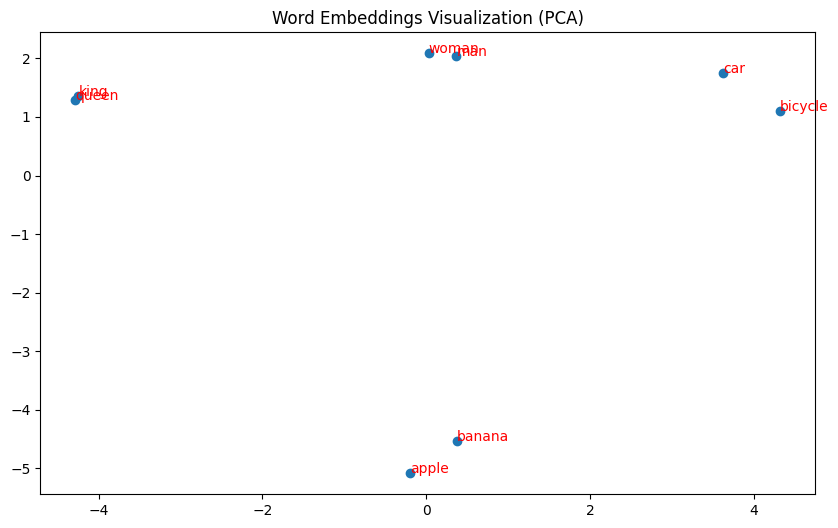

In [49]:
# Visualization (PCA and t-SNE)
words_to_visualize = ["king", "queen", "man", "woman", "apple", "banana", "car", "bicycle"]
embeddings_to_visualize = [model.encode(word) for word in words_to_visualize]

# PCA for 2D Visualization
pca = PCA(n_components=2)
reduced_embeddings_pca = pca.fit_transform(embeddings_to_visualize)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_pca[:, 0], reduced_embeddings_pca[:, 1])
for i, word in enumerate(words_to_visualize):
    plt.annotate(word, xy=(reduced_embeddings_pca[i, 0], reduced_embeddings_pca[i, 1]), color='red')
plt.title("Word Embeddings Visualization (PCA)")
plt.show()

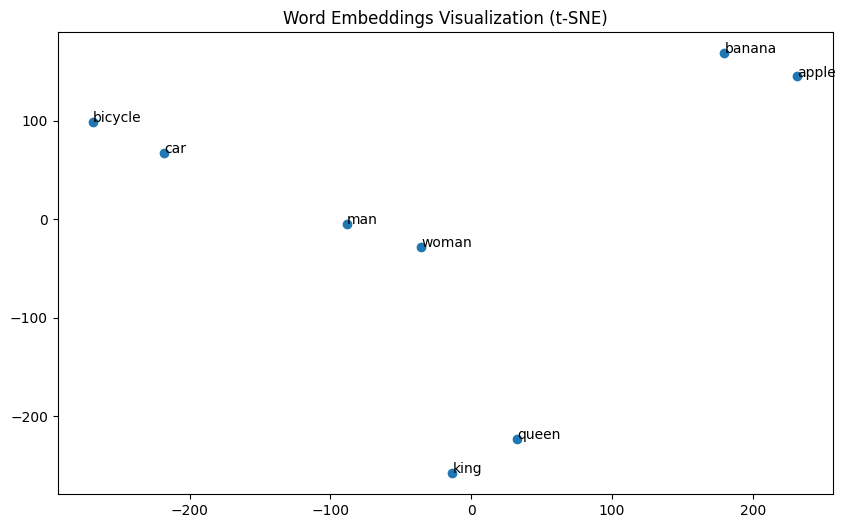

In [52]:
# t-SNE for 2D Visualization
embeddings_to_visualize = np.array(embeddings_to_visualize)

tsne = TSNE(n_components=2, random_state=0, perplexity=2)
reduced_embeddings_tsne = tsne.fit_transform(embeddings_to_visualize)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1])
for i, word in enumerate(words_to_visualize):
    plt.annotate(word, xy=(reduced_embeddings_tsne[i, 0], reduced_embeddings_tsne[i, 1]))
plt.title("Word Embeddings Visualization (t-SNE)")
plt.show()

**Part 3: Designing a Novel Dissimilarity Metric (20 points)**

* Define a custom dissimilarity score that goes beyond cosine similarity. Possible
approaches include:
  * Euclidean distance (How far apart words are in vector space).
  * Word entropy-based dissimilarity (How uncommon two words are relative to
each other in corpora).
  * Semantic contrast measure (Using external knowledge bases like WordNet).
  
* Either design your own metric or cite an existing one from literature (provide a proper
reference). Explain why your metric captures novelty/diversity better than cosine
similarity alone.
* Allow users to toggle between different similarity/dissimilarity measures via function
parameters.
* Visualization Requirement:
  * Plot the ranking of words based on their similarity/dissimilarity to a given word
(e.g., how words like "cat" rank against "dog," "lion," and "table" using different
metrics).
  * Use a heatmap to demonstrate and compare similarity and dissimilarity across
multiple (any number of your choice) word pairs.

In [54]:
from collections import Counter
# Simplified Corpus
corpus = ["cat", "dog", "lion", "table", "kitten", "tiger", "apple", "banana", "car", "bicycle", "cat", "dog", "lion", "cat", "apple"]

# Word Frequency and Probability
word_counts = Counter(corpus)
total_words = len(corpus)
word_probabilities = {word: count / total_words for word, count in word_counts.items()}

In [55]:
word_counts

Counter({'cat': 3,
         'dog': 2,
         'lion': 2,
         'table': 1,
         'kitten': 1,
         'tiger': 1,
         'apple': 2,
         'banana': 1,
         'car': 1,
         'bicycle': 1})

In [56]:
# Word Entropy Function
def word_entropy(word, probabilities):
    if word not in probabilities:
        return 0  # Handle OOV words with 0 entropy (simplified)
    probability = probabilities[word]
    if probability == 0:
        return 0  # Avoid log(0)
    return -probability * math.log2(probability)

# Entropy-Based Dissimilarity
def entropy_dissimilarity(word1, word2, probabilities):
    entropy1 = word_entropy(word1, probabilities)
    entropy2 = word_entropy(word2, probabilities)
    return abs(entropy1 - entropy2)

In [57]:
# Toggle Between Similarity/Dissimilarity Measures
def calculate_metric(word1, word2, metric='cosine'):
    embedding1 = model.encode(word1)
    embedding2 = model.encode(word2)
    if metric == 'cosine':
        return cosine_similarity(embedding1, embedding2)
    elif metric == 'entropy':
        return entropy_dissimilarity(word1, word2, word_probabilities)
    else:
        raise ValueError("Invalid metric. Choose 'cosine' or 'entropy'.")

In [58]:
# Ranking Words Based on Similarity/Dissimilarity
def rank_words(target_word, comparison_words, metric='cosine'):
    scores = []
    for word in comparison_words:
        scores.append(calculate_metric(target_word, word, metric))
    if metric == 'cosine':
        sorted_indices = np.argsort(scores)[::-1]  # Descending order for cosine
    else:
        sorted_indices = np.argsort(scores)  # Ascending order for entropy
    ranked_words = [comparison_words[i] for i in sorted_indices]
    return ranked_words, [scores[i] for i in sorted_indices]

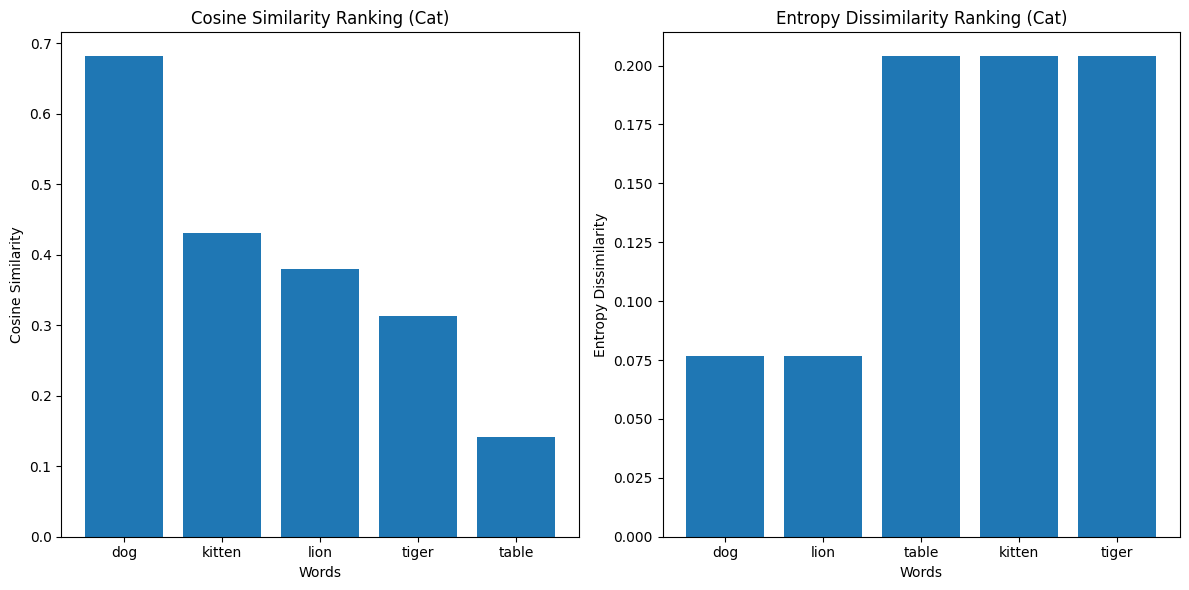

In [60]:
import math
# Visualization: Ranking Plot
target_word = "cat"
comparison_words = ["dog", "lion", "table", "kitten", "tiger"]

ranked_cosine, scores_cosine = rank_words(target_word, comparison_words, metric='cosine')
ranked_entropy, scores_entropy = rank_words(target_word, comparison_words, metric='entropy')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(ranked_cosine, scores_cosine)
plt.title("Cosine Similarity Ranking (Cat)")
plt.xlabel("Words")
plt.ylabel("Cosine Similarity")

plt.subplot(1, 2, 2)
plt.bar(ranked_entropy, scores_entropy)
plt.title("Entropy Dissimilarity Ranking (Cat)")
plt.xlabel("Words")
plt.ylabel("Entropy Dissimilarity")

plt.tight_layout()
plt.show()

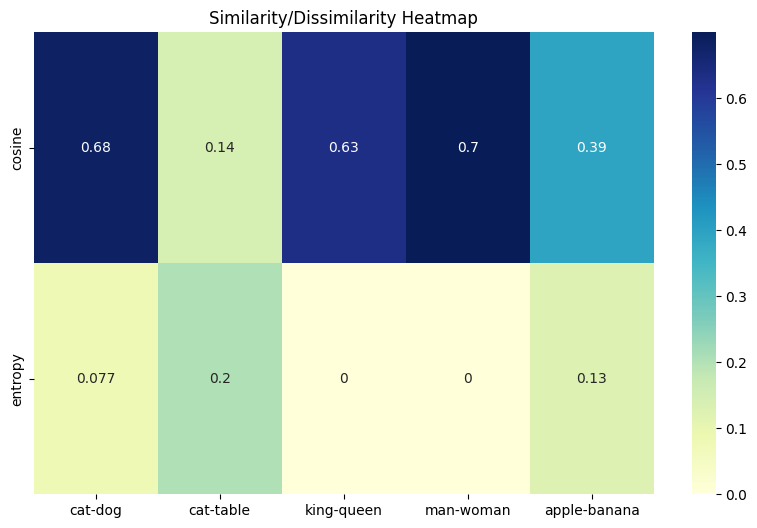

In [62]:
import seaborn as sns
# Visualization: Heatmap
word_pairs_heatmap = [("cat", "dog"), ("cat", "table"), ("king", "queen"), ("man", "woman"), ("apple", "banana")]
metrics = ['cosine', 'entropy']
heatmap_data = np.zeros((len(metrics), len(word_pairs_heatmap)))

for i, metric in enumerate(metrics):
    for j, pair in enumerate(word_pairs_heatmap):
        heatmap_data[i, j] = calculate_metric(pair[0], pair[1], metric)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", xticklabels=[f"{p[0]}-{p[1]}" for p in word_pairs_heatmap], yticklabels=metrics)
plt.title("Similarity/Dissimilarity Heatmap")
plt.show()